## SuperDataScience Podcast NLP Analysis

### Notebook# 6: Keyword Extraction


<div style="width: 500px;">
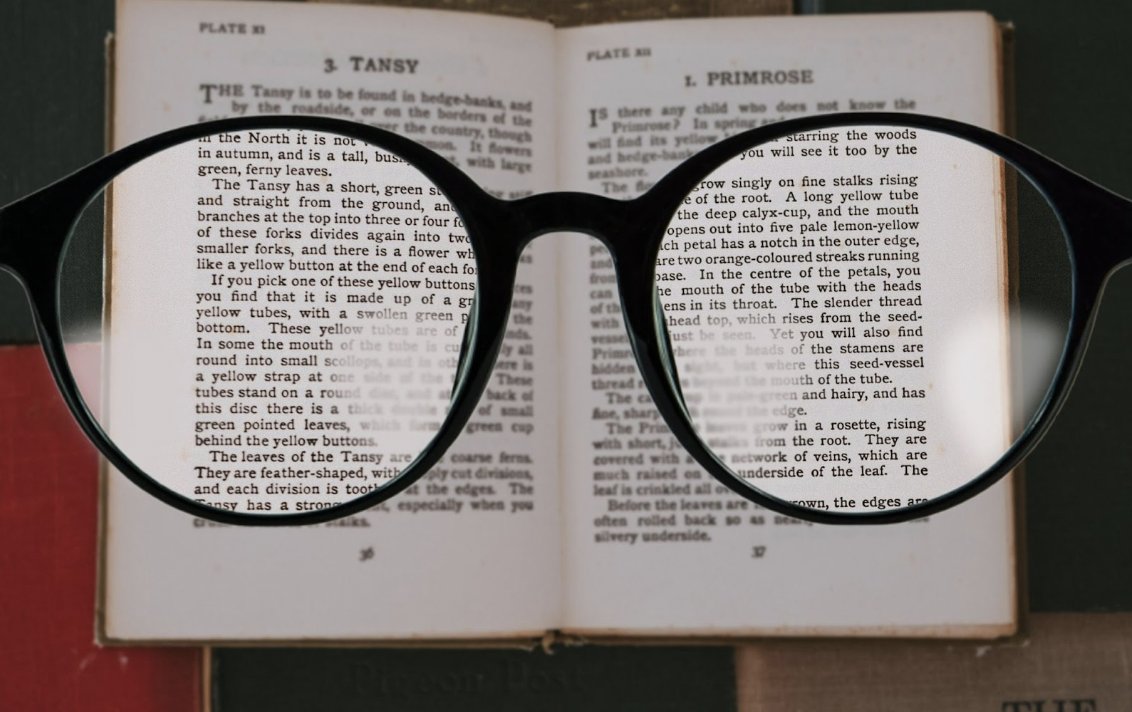

In [1]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import yake
import string
import numpy as np

In [ ]:
sds_data = pd.read_csv('../data/sds_ds_text.csv')

### Preprocessing Text

In [ ]:
sds_ds_processed = pd.DataFrame(sds_data.groupby(['episode_number', 'episode_name', 'length_episode', 'class', 'guest_name', 'host_episode', 'episode_year', 'episode_date'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

In [ ]:
# Function to clean the text 
def lower_text(text):  
    # Lowercase the text
    if isinstance(text, float):
        return text
    text = text.lower()
    # Remove punctuation from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove digits from the text
    text = ''.join(char for char in text if not char.isdigit())
    return text

In [ ]:
sds_ds_processed['episode_split_text'] = sds_ds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_data['episode_split_text'] = sds_data['episode_split_text'].apply(lower_text)

In [ ]:
sds_data.to_csv('../data/sds_BERTopic_split.csv')

## Generating keywords for Data Science Episodes

In [ ]:
sds_ds_processed['episode_keywords_1_2'] = None

In [ ]:
sds_ds_processed['episode_keywords_1_3'] = None

In [ ]:
sds_ds_processed

In [ ]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_ds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_ds_processed.at[i, 'episode_keywords_1_3'] = keywords

In [ ]:
yake_keyword_extractor(sds_ds_processed['episode_split_text'])

In [ ]:
sds_ds_processed

In [ ]:
def tuple_extractor(row):
    words = [t[0].replace(" ", "_") for t in row]
    return " ".join(words)

In [ ]:
sds_ds_processed['keywords1_3'] = sds_ds_processed['episode_keywords_1_3'].apply(tuple_extractor)

In [ ]:
sds_ds_processed.to_csv('../data/keywords1_3_9June.csv', index = False)

In [ ]:
sds_ds_processed['keywords'] = sds_ds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_ds_processed

In [ ]:
sds_ds_processed.to_csv('../data/sds_ds_keywords.csv', index = False)

## Generating keywords for non-Data Science Episodes

In [ ]:
sds_nds_processed = pd.DataFrame(sds_non_data.groupby(['episode_number', 'episode_name', 'length_episode', 'context_episode', 'guest_name', 'host_episode', 'episode_year'])['episode_split_text'].agg(lambda x: ' '.join(str(i) for i in x))).reset_index()

In [ ]:
sds_nds_processed['episode_split_text'] = sds_nds_processed['episode_split_text'].apply(processed_text)

In [ ]:
sds_nds_processed['episode_keywords'] = None

In [ ]:
# Function to generate 100 keywords per episode using Yake library to store keywords in one column as list
def yake_keyword_extractor(doc):
    global sds_nds_processed
    
    for i, episode_text in doc.iteritems():
        max_ngram_size = 3
        deduplication_threshold = 0.3
        windowSize = 1
        numOfKeywords = 100
        kw_extractor = yake.KeywordExtractor(n = max_ngram_size, dedupLim = deduplication_threshold , windowsSize = windowSize, top = numOfKeywords)
        keywords = kw_extractor.extract_keywords(episode_text)
        sds_nds_processed.at[i, 'episode_keywords'] = keywords

In [ ]:
yake_keyword_extractor(sds_nds_processed['episode_split_text'])

In [ ]:
sds_nds_processed['keywords'] = sds_nds_processed['episode_keywords'].apply(tuple_extractor)

In [ ]:
sds_nds_processed

In [ ]:
sds_nds_processed.to_csv('../data/sds_nds_keywords.csv', index = False)

### Count Vectorizer and Class-Based Tfidf

In [ ]:
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import normalize

In [ ]:
sds_ds_keywords1_3 = pd.read_csv('../data/keywords1_3_9June.csv')

keywords_per_class1_3 = sds_ds_keywords1_3.groupby('class')['keywords1_3'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class1_3 = keywords_per_class1_3.rename(columns={'class': 'Class', 'keywords1_3': 'Document'})

In [ ]:
keywords_per_class1_3

In [ ]:
keywords_per_class['Document'].loc[0]

In [ ]:
sds_ds_keywords = pd.read_csv('../data/sds_ds_keywords.csv')

keywords_per_class = sds_ds_keywords.groupby('class')['keywords'].apply(' '.join).reset_index()

# Rename the columns to match the original code
keywords_per_class = keywords_per_class.rename(columns={'class': 'Class', 'keywords': 'Document'})

In [ ]:
keywords_per_class

In [ ]:
keywords_per_class

In [ ]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [ ]:
# Create c-TF-IDF
count = CountVectorizer().fit_transform(keywords_per_class1_3.Document)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class1_3)).toarray()

In [ ]:
# Create bag of words using count vectorizer
count_vectorizer = CountVectorizer().fit(keywords_per_class1_3.Document)
count = count_vectorizer.transform(keywords_per_class1_3.Document)
words = count_vectorizer.get_feature_names_out()

In [ ]:
count_vectorizer.vocabulary_

In [ ]:
len(count_vectorizer.vocabulary_)

In [ ]:
count.shape

In [ ]:
word_counts = pd.DataFrame({
    'words': count_vectorizer.get_feature_names_out(),
    'frequency': np.array(count.sum(axis = 0)).flatten()
})
word_counts.sort_values('frequency', ascending = False)

In [ ]:
word_counts[word_counts['frequency'] < 5]

In [ ]:
# class based tfidf
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(keywords_per_class1_3)).toarray()

In [ ]:
# find top words in each class
top_words_per_class = []
for i, class_docs in enumerate(keywords_per_class1_3.Document):
    tfidf_scores = ctfidf[i]
    top_word_indices = np.argsort(tfidf_scores)[:20]  # index
    top_words = [words[idx] for idx in top_word_indices]  # feature name
    top_words_per_class.append(top_words)

class_most_common_20 = pd.DataFrame({'Class': keywords_per_class.Class, 'top_Words': top_words_per_class})

In [ ]:
class_most_common_20

In [ ]:
class_most_common_20['top_Words'].loc[0]

In [ ]:
# find unique words in each class
unique_words_per_class = []
for i, class_docs in enumerate(keywords_per_class1_3.Document):
    tfidf_scores = ctfidf[i]
    unique_word_indices = np.argsort(tfidf_scores)[-100:][::-1]  # index
    unique_words = [words[idx] for idx in unique_word_indices]  # feature name
    unique_words_per_class.append(unique_words)

class_unique_100 = pd.DataFrame({'Class': keywords_per_class1_3.Class, 'unique_Words': unique_words_per_class})


In [ ]:
class_unique_100

In [ ]:
class_unique_100['unique_Words'].loc[6]

In [ ]:
class_unique_100['unique_Words'].loc[0]

In [ ]:
class_unique_50['Class'].unique()

In [ ]:
class_unique_50.to_csv('../data/keywords_u20.csv')

### Generate word cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:

all_keywords = ' '.join(keywords_per_class1_3.Document)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
all_keywords = ' '.join(map(str, class_unique_100.unique_Words))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
sds_ds_bert = pd.read_csv('../data/sds_ds_keywords.csv')

In [ ]:
sds_ds_bert["episode_keywords"] = None
sds_ds_bert["keywords"] = None

## KeyBERT

In [ ]:
from keybert import KeyBERT

In [ ]:
sds_ds_bert

In [ ]:
def bert_keyword_extractor(doc):
    kw_model = KeyBERT()
    global sds_ds_bert
    stopwords = list(STOP_WORDS)
    
    for i, episode_text in doc.iteritems():
        keywords = kw_model.extract_keywords(episode_text, keyphrase_ngram_range=(1, 3), stop_words = stopwords, top_n = 100, use_mmr=True, diversity=0.7)
        sds_ds_bert.at[i, 'episode_keywords'] = keywords

In [ ]:
bert_keyword_extractor(sds_ds_bert['episode_split_text'])

In [ ]:
sds_ds_bert['episode_keywords'].loc[0]

In [ ]:
# https://maartengr.github.io/BERTopic/index.html